<a href="https://colab.research.google.com/github/Fjolnirr/OliveTreeCounting/blob/main/pytorch_maskrcnn_training_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Drive

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Libraries

In [13]:
import random
from math import log10, sqrt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab.patches import cv2_imshow

Settings (batch_size, image_size, num_classes, train_directories, device)

In [ ]:
batchSize = 1
imageSize = [60, 60]
numClasses = 2
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  # train on the GPU or on the CPU, if a GPU is not available
trainDir = "/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train"

imgs = []
for pth in os.listdir(trainDir):
    if(pth.startswith(".")):
      continue
    imgs.append(trainDir + "/" + pth +"/")   
print(imgs)


['/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train102/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train101/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train103/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train100/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train106/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train10/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train104/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train105/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train0/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train114/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train115/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train11/', '/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train111/', '/content/drive/MyDrive/M

Data Loader

In [ ]:
def loadData(raw_image = 'image.jpg', masks_folder = 'Masks'):
    batch_Imgs = []
    batch_Data = []  # load images and masks

    for i in range(batchSize):
        idx = random.randint(0, len(imgs) - 1)
        img = cv2.imread(os.path.join(imgs[idx], raw_image))
        img = cv2.resize(img, tuple(imageSize), cv2.INTER_LINEAR)
        maskDir = os.path.join(imgs[idx], masks_folder)
        masks = []
        for mskName in os.listdir(maskDir):
            currMask = (cv2.imread(maskDir + '/' + mskName, 0) > 0).astype(np.uint8)  # Read the instance mask
            currMask = cv2.resize(currMask, tuple(imageSize), cv2.INTER_NEAREST)
            masks.append(currMask)  # get bounding box coordinates for each mask

        num_objs = len(masks)
        if num_objs == 0: return loadData()  # if image have no objects just load another image
        boxes = torch.zeros([num_objs, 4], dtype=torch.float32) # empty no_of_mask_object x 4 array(tensor) to store box coordinates of each obj later on..

        for i in range(num_objs):
            '''Store each instance masks bounding box coordinates to boxes array(tensor)'''
            x, y, w, h = cv2.boundingRect(masks[i])
            if (x >= (x + w) or y >= (y + h)):
              boxes[i] = torch.tensor([x, y, x + w + 1, y + h + 1])
              print('Fucked up here : ' + maskDir + ' Mask_no : ' + str(i-1))
              print('x : {} y : {} w : {} h : {}'.format(x,y,w,h))
            else:
              boxes[i] = torch.tensor([x, y, x + w, y + h])


        masks = torch.as_tensor(masks, dtype=torch.uint8) # Transform masks array into a tensor (which is holding all instance masks)
        img = torch.as_tensor(img, dtype=torch.float32)   # Transform image array into a tensor
        
        #Store boxes, labels, masks data into data dictionary
        data = {} # create empty data dictionary
        data["boxes"] = boxes
        data["labels"] = torch.ones((num_objs,), dtype=torch.int64)  # there is only one class
        data["masks"] = masks
        batch_Imgs.append(img)   # load images
        batch_Data.append(data)  # load masks(with boxes, labels)

    batch_Imgs = torch.stack([torch.as_tensor(tensor_im) for tensor_im in batch_Imgs], 0) # Stack all image in a tensor 
    batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
    return batch_Imgs, batch_Data


In [ ]:
a = np.array([[[2,3,6]], [[1,4,7]]])
b = np.array([[[1,4,7]], [[2,3,6]]])
d = np.array([[[0,5,8]], [[2,3,6]]])
a = torch.as_tensor(a)
b = torch.as_tensor(b)
d = torch.as_tensor(d)
c = torch.stack([a,b,d],0)
print(c)
c.swapaxes(1,3).swapaxes(2,3)

In [ ]:
def save_network(network, epoch_label, saveDir):
    save_filename = 'net_{}.pth'.format(epoch_label)
    #save_path = os.path.join('./savedModels', save_filename)
    torch.save(network.state_dict(), saveDir)
    print("Save model to: {}{}.pth".format(saveDir,epoch_label))

Loading the Model

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained on COCO
in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,
                                                  num_classes=numClasses)  # replace the pre-trained head with a new one 
model.to(device)  # move model to the right device

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

Start Training

In [ ]:
weightDir = "/content/drive/MyDrive/MSc/Thesis/Weights/epoch"
epoch = 4000

for i in range(epoch+1):

   images, targets = loadData()
   images = list(image.to(device) for image in images) # Extract all images and upload on device(here : cuda)
   targets=[{k: v.to(device) for k,v in t.items()} for t in targets] # # Extract all data and upload on device(here : cuda)

   optimizer.zero_grad() 
   loss_dict = model(images, targets) #input the images and targets list to model
   losses = sum(loss for loss in loss_dict.values())
   
   losses.backward()
   optimizer.step()
   
   print('Epoch {}/{} - loss: {}'.format(i, epoch, str(losses.item())))
   if i%500==0:
           #save_network(model.state_dict(), i, saveDir = weightDir)
           torch.save(model, weightDir+str(i)+".pth")
           

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch 0/4000 - loss: 451.1965637207031
Epoch 1/4000 - loss: 665.52392578125
Epoch 2/4000 - loss: 258.51531982421875
Epoch 3/4000 - loss: 158.27378845214844
Epoch 4/4000 - loss: 115.40607452392578
Epoch 5/4000 - loss: 108.65045166015625
Epoch 6/4000 - loss: 106.20844268798828
Epoch 7/4000 - loss: 35.271141052246094
Epoch 8/4000 - loss: 31.069820404052734
Epoch 9/4000 - loss: 30.666643142700195
Epoch 10/4000 - loss: 101.71174621582031
Epoch 11/4000 - loss: 35.73869323730469
Epoch 12/4000 - loss: 95.70584106445312
Epoch 13/4000 - loss: 57.48142623901367
Epoch 14/4000 - loss: 21.336902618408203
Epoch 15/4000 - loss: 34.74898910522461
Epoch 16/4000 - loss: 22.526269912719727
Epoch 17/4000 - loss: 101.56281280517578
Epoch 18/4000 - loss: 65.29533386230469
Epoch 19/4000 - loss: 69.7227554321289
Epoch 20/4000 - loss: 46.35652160644531
Epoch 21/4000 - loss: 38.90545654296875
Epoch 22/4000 - loss: 45.33219528198242
Epoch 23/4000 - loss: 37.62221908569336
Epoch 24/4000 - loss: 70.892822265625
Epo

In [ ]:
torch.cuda.empty_cache()

torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
#@title Prediction_mask kodu
def prediction_mask(weight_path, im="/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg"):
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
  model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
  in_features = model.roi_heads.box_predictor.cls_score.in_features 
  model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
  model.load_state_dict(torch.load(weight_path))
  model.to(device)# move model to the right devic
  model.eval()

  images = cv2.imread(im)
  images = cv2.resize(images, (600,600), cv2.INTER_LINEAR)
  images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
  images=images.swapaxes(1, 3).swapaxes(2, 3)
  images = list(image.to(device) for image in images)

  with torch.no_grad():
    pred = model(images)
    pred_mask = pred[0]['masks'][0].cpu().data.numpy()
    bbox = pred[0]['boxes'][0].cpu().data.numpy()
    bbox = [int(x) for x in bbox]

  return pred_mask[0], bbox

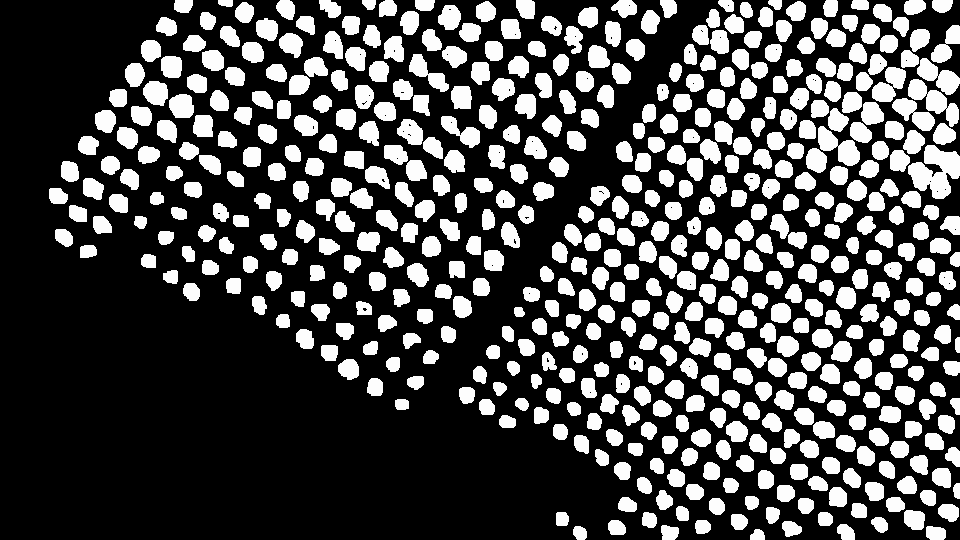

[[[575 526]]

 [[574 527]]

 [[574 528]]

 [[573 529]]

 [[573 534]]

 [[576 537]]

 [[576 538]]

 [[577 539]]

 [[584 539]]

 [[586 537]]

 [[586 531]]

 [[585 530]]

 [[585 529]]

 [[584 528]]

 [[583 528]]

 [[582 527]]

 [[581 527]]

 [[580 526]]]


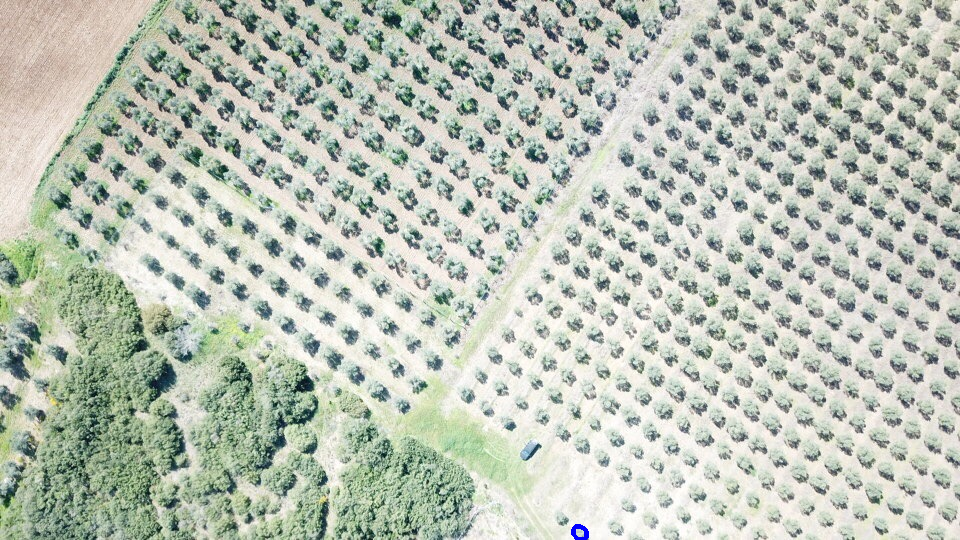

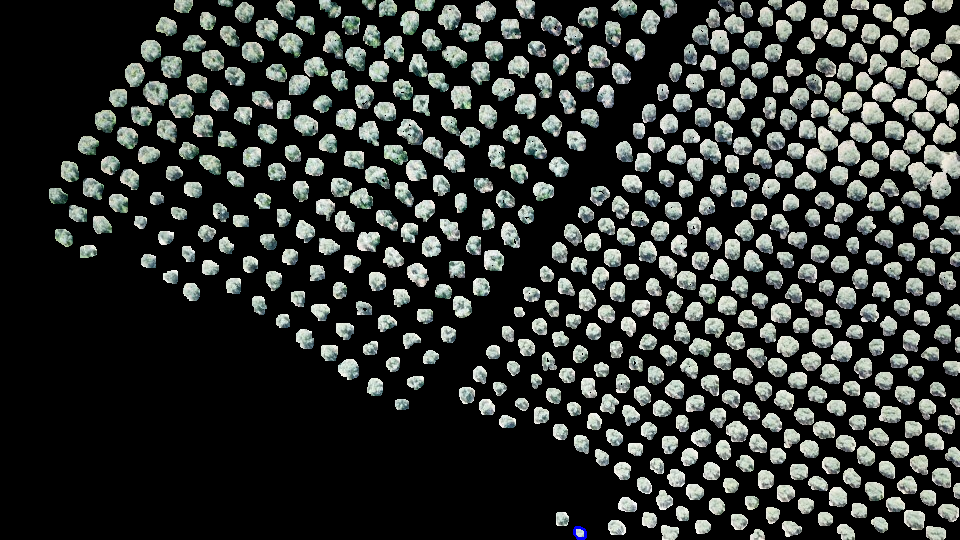

In [ ]:
im = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Image.jpg")
#im = cv2.resize(im, (600,600))
gry = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train1/Masks/im1_mask.png",0)
#ret,thresh1 = cv2.threshold(gry,1,1,cv2.THRESH_BINARY)
cv2_imshow(gry*255)
ret, thresh = cv2.threshold(gry,1,1,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[2]
print(cnt)
cv2.drawContours(im, [cnt], 0, (255,0,0), 3)
cv2_imshow(im)

res = cv2.bitwise_and(im,im, mask = thresh)
cv2_imshow(res)
#####cv2.imwrite("/content/drive/MyDrive/ColabWorkspace/UAVdataset/Train/Train1/Masks/mask3.png", thresh1)


TEST SECTION

In [ ]:
print("Model's state_dict:")
for param_tensor in x.state_dict():
    print(param_tensor, "\t", x.state_dict()[param_tensor].size())

print()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')  
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
x = torch.load("epoch4000.pth")

model.load_state_dict(x.state_dict())
model.to(device)# move model to the right devic
model.eval()

In [132]:
def image_divider(src, imSize = (540, 960), xGridSize = 60, yGridSize = 60):
        sub_images = []
        # Split the image into grids and save them
        counter = 0
        for j in range(0, imSize[0], yGridSize):
            for i in range(0, imSize[1], xGridSize):
                roi = src[j:j + yGridSize, i:i + xGridSize]
                print("Sub-image {} generated and appended to sub_images list.".format(counter))
                print(np.shape(roi))
                roi = torch.as_tensor(roi, dtype=torch.float32)#.unsqueeze(0)
                print(roi.size())
                roi=roi.swapaxes(0, -1).swapaxes(1, 2)
                print(roi.size())
                roi = list(roi.to(device) for image in roi)
                sub_images.append(roi)
                counter += 1
        return sub_images

In [140]:
#images = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Train/Train62/image.jpg")
img = cv2.imread("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Test/gry (7).jpg")
#cv2.imwrite("/content/drive/MyDrive/MSc/Thesis/OliveTreeDataset/Test/gry (7).jpg",images)
#images = cv2.resize(images, (60,60), cv2.INTER_LINEAR)


#images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
#images=images.swapaxes(1, 3).swapaxes(2, 3)
#images = list(image.to(device) for image in images)


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
preds = []
sub_images = image_divider(img)
with torch.no_grad():
    for subs in sub_images:
      pred = model(subs)
      preds.append(pred)

In [136]:
def stitcher(sub_results, imSize = (540, 960), xGridSize = 60, yGridSize = 60):
  frame = np.zeros((540, 960,3), dtype='uint8')
  counter = 0
  for j in range(0, imSize[0], yGridSize):
      for i in range(0, imSize[1], xGridSize):
          frame[j:j + yGridSize, i:i + xGridSize] = sub_results[counter]
          counter += 1
  return frame


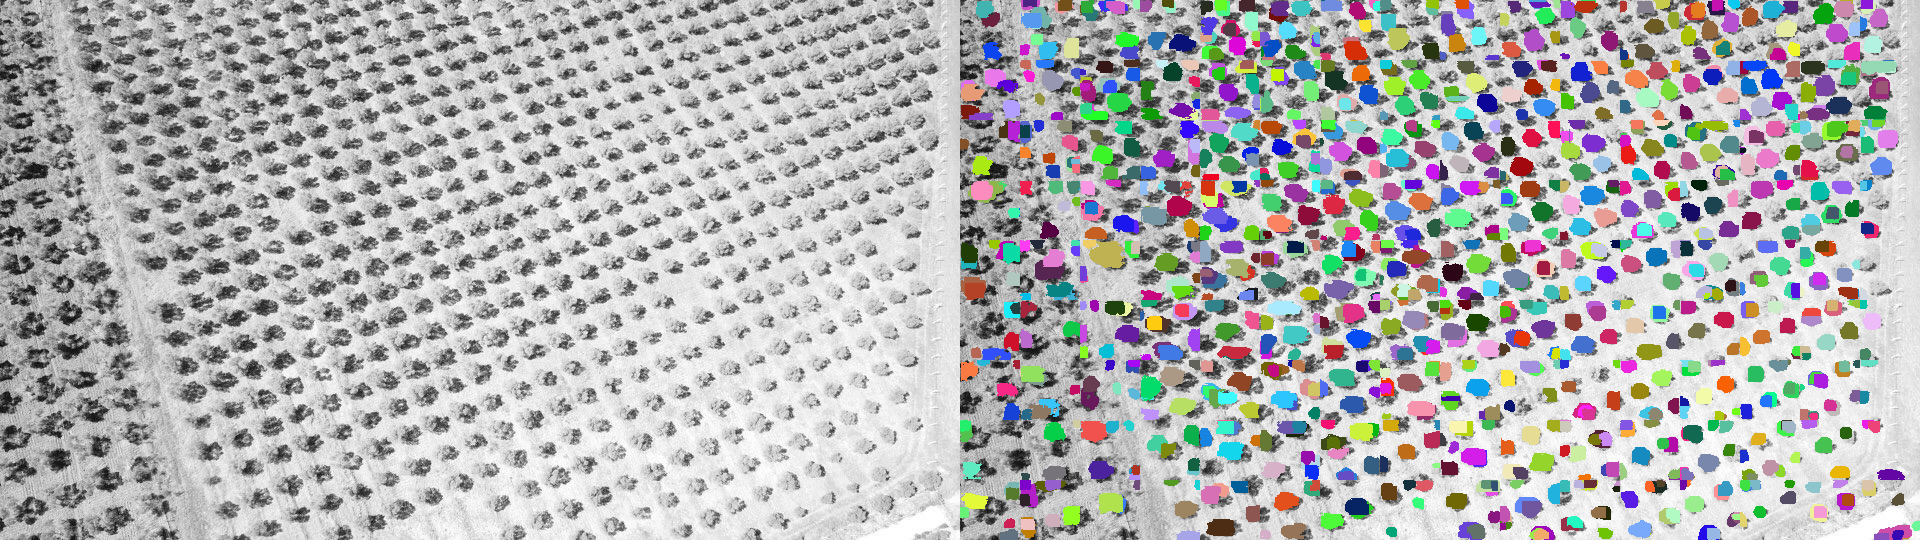

1157


In [159]:
from google.colab.patches import cv2_imshow
sub_results = []
treeCount = 0
for k in range(len(sub_images)):
  im= sub_images[k][0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
  im2 = im.copy()
  for i in range(len(preds[k][0]['masks'])):
      msk=preds[k][0]['masks'][i,0].detach().cpu().numpy()
      scr=preds[k][0]['scores'][i].detach().cpu().numpy()
      if scr>0.8 :
          im2[:,:,0][msk>0.5] = random.randint(0,255)
          im2[:, :, 1][msk > 0.5] = random.randint(0,255)
          im2[:, :, 2][msk > 0.5] = random.randint(0, 255)
          treeCount += 1
  sub_results.append(im2)

frame = stitcher(sub_results)
cv2_imshow(np.hstack((img,frame)))
print(treeCount)
#cv2.waitKey(0)

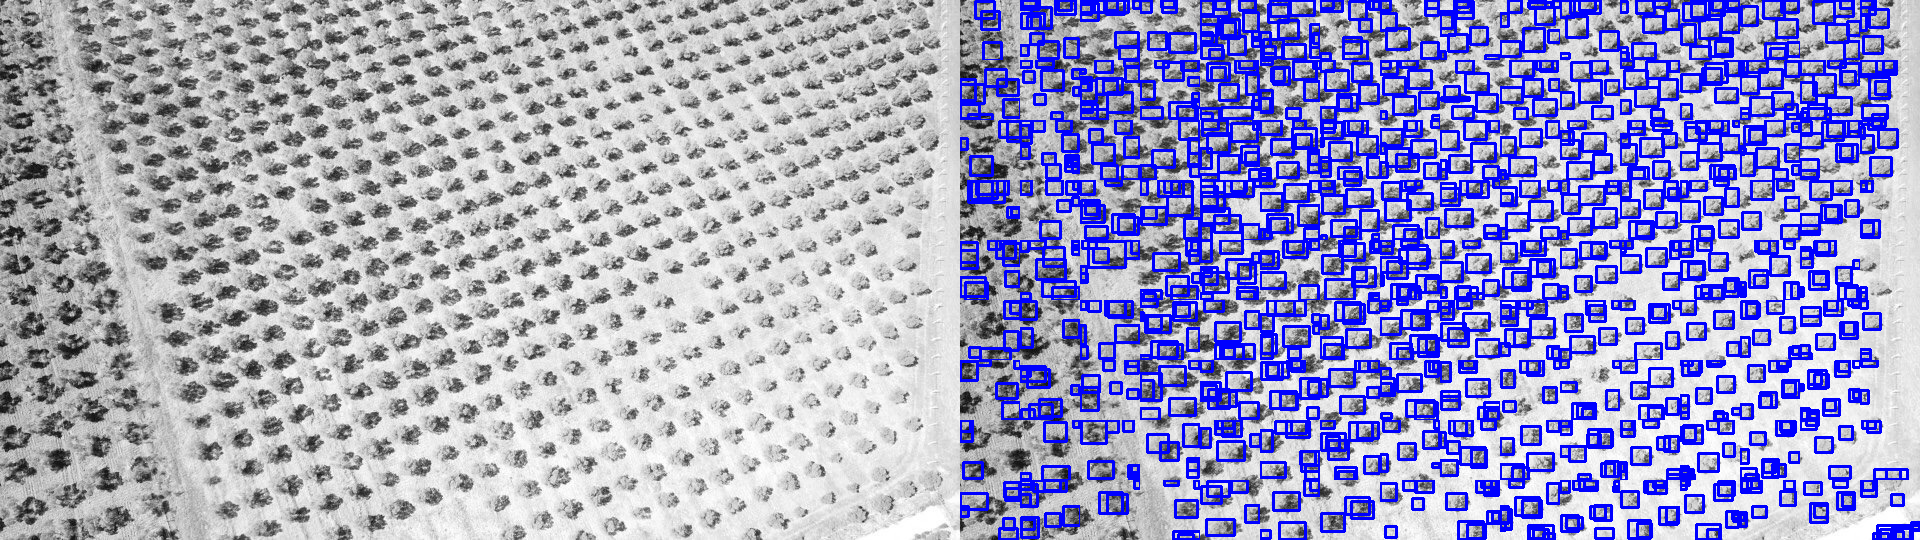

1157


In [160]:
sub_results = []
treeCount = 0
for k in range(len(sub_images)):
  im= sub_images[k][0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)
  im2 = im.copy()
  for i in range(len(preds[k][0]['masks'])):
      msk=preds[k][0]['masks'][i,0].detach().cpu().numpy()
      scr=preds[k][0]['scores'][i].detach().cpu().numpy()
      bbox = preds[k][0]['boxes'][i].detach().cpu().data.numpy()
      bbox = [int(b) for b in bbox]
      if scr>0.8 :
          cv2.rectangle(im2,(bbox[0],bbox[1]), (bbox[2], bbox[3]),(255,0,0),2)
          treeCount += 1
  
  sub_results.append(im2)

frame = stitcher(sub_results)
cv2_imshow(np.hstack((img,frame)))
print(treeCount)
